In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [3]:
from numpy import pi as pi
DQPSK_PHASE_TRANSITION_LUT = np.array([pi/4, 3*pi/4, -pi/4, -3*pi/4], dtype=np.float64)
DQPSK_TRANSITION_PHASOR_LUT = np.exp(1j * DQPSK_PHASE_TRANSITION_LUT).astype(np.complex64)
np.random.seed(10)

In [4]:
from numpy import complex64, int16, float64, uint8
from numpy.typing import NDArray
def dqpskModulator(inputData: NDArray[uint8], 
                   phaseRef: np.complex64 = np.complex64(1 + 0j)) -> NDArray[complex64]:
    
    assert inputData.ndim == 1
    assert inputData.size % 2 == 0 # must have even number of bits,

    # reshape to have even and odd bits [b0, b1]
    bitPairs = inputData.reshape(-1,2)
    # map the even odd bits into a 4-entry code to map phase transistion quickly from LUT
    codedTransistions = (bitPairs[:, 0] << 1 ) | bitPairs[:, 1] # maps into value [b0b1, b2b3, ...]
    
    # grayTransistion -> 0=0b00, 1=0b01, 2=0b10, 3=0b11, lookup the phase transistion table in phasor form
    dPhasor = DQPSK_TRANSITION_PHASOR_LUT[codedTransistions]
    
    return (np.cumprod(dPhasor) * phaseRef).astype(complex64)

In [5]:
input_binary_data = np.random.randint(0, 2, size=432)
print(input_binary_data)

[1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1
 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0
 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0
 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1
 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0
 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1
 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0]


In [6]:
modulated_data = dqpskModulator(input_binary_data)

In [7]:
print(modulated_data[-10:])

[ 7.071067e-01+7.071067e-01j  9.999999e-01+3.435261e-10j
  7.071067e-01-7.071067e-01j  3.435261e-10-9.999999e-01j
 -7.071067e-01+7.071067e-01j  3.435261e-10-9.999999e-01j
 -7.071067e-01+7.071067e-01j  3.435261e-10-9.999999e-01j
 -7.071067e-01-7.071067e-01j -3.435261e-10-9.999999e-01j]


In [8]:
def oversampleData(inputData: NDArray[complex64], overSampleRate:int):
    outputData = np.zeros(shape=(2, inputData.size*overSampleRate), dtype=int16)
    # because the modulation mapped only on the unit circle, the max value is 1, and min is zero
    # for this module, we quantize scaling by 0.5 then multiplying by our maximum value to provide headroom in later calculations
    tempIvalues = (inputData.real* ((2 ** 15) - 1)) / 2
    tempQvalues = (inputData.imag* ((2 ** 15) - 1)) / 2
    outputData[0][0::overSampleRate] = tempIvalues.astype(int16)
    outputData[1][0::overSampleRate] = tempQvalues.astype(int16)
    return outputData

In [9]:
sps = 4
quantized_data = oversampleData(modulated_data, sps)
print(quantized_data)

[[-11584      0      0 ...      0      0      0]
 [-11584      0      0 ...      0      0      0]]


In [10]:
from numpy import sin, cos
def rrc_calculator(OSR:int, symbolSpan:int,beta:int=0.35):
    N = (symbolSpan * OSR) + 1
    n0 = (N-1)//2
    h = np.zeros(shape=N, dtype=np.float32)
    for n in range(N):
        tn = ((n-n0)/8)
        if np.isclose(tn, 0):
            h[n] = 1 - beta + ((4*beta)/pi)
        else:
            if np.isclose(tn, (1/(4*beta))) or np.isclose(tn,(-1/(4*beta))):
                h[n] = (beta/(2**(0.5)))*((1+(2/pi))*sin(pi/(4*beta)) + (1-(2/pi))*cos(pi/(4*beta)))
            else:
                h[n] = ((sin(pi*tn*(1-beta)))+(4*beta*tn*cos(pi*tn*(1+beta))))/(pi*tn*(1-((4*beta*tn)**2)))
    h /= h.sum(axis=0)
    return h
    
            
        

In [16]:
h_rrc = rrc_calculator(sps, 11, 0.35)
print(h_rrc)

[-0.00182159  0.00035123  0.00315801  0.00598406  0.00805615  0.00860233
  0.0070421   0.00316825 -0.00272128 -0.00977777 -0.01666406 -0.0217266
 -0.02325611 -0.01979566 -0.01044126  0.00492287  0.02550465  0.04963157
  0.07493094  0.09864051  0.11800174  0.13067092  0.13507804  0.13067092
  0.11800174  0.09864051  0.07493094  0.04963157  0.02550465  0.00492287
 -0.01044126 -0.01979566 -0.02325611 -0.0217266  -0.01666406 -0.00977777
 -0.00272128  0.00316825  0.0070421   0.00860233  0.00805615  0.00598406
  0.00315801  0.00035123 -0.00182159]


In [17]:
print(len(h_rrc))
polyphase_interpolater_length = np.ceil(len(h_rrc)/sps)

45


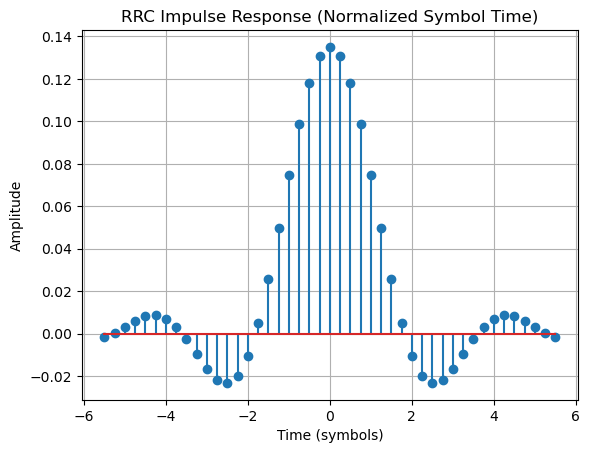

In [18]:
N = len(h_rrc)
n0 = (N - 1) // 2

t_sym = (np.arange(N) - n0) / sps

plt.figure()
plt.stem(t_sym, h_rrc)
plt.xlabel("Time (symbols)")
plt.ylabel("Amplitude")
plt.title("RRC Impulse Response (Normalized Symbol Time)")
plt.grid(True)
plt.show()

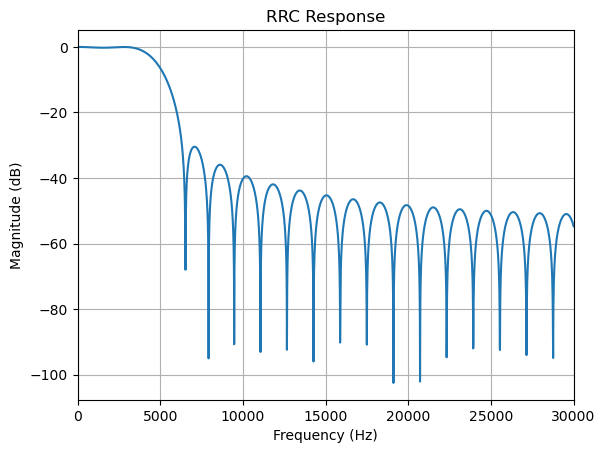

In [19]:
from numpy.fft import fft, fftshift

Fs = (sps * 18000)  # sampling rate (Hz)
N_fft = 8192

H = sp.fft.rfft(h_rrc, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("RRC Response")
plt.grid(True)
plt.xlim(0, 30_000)
plt.show()

In [20]:
Q = 17
scale = 2**Q
h_fixed = np.round(h_rrc * scale).astype(np.int32)
h_fixed = np.clip(h_fixed, -2**17, 2**17 -1)
print("Min:", h_fixed.min(), "Max:", h_fixed.max())

Min: -3048 Max: 17705
